# 2. Exploración y análisis de datos

## 2.1 Descripción del conjunto de datos

**Origen y contexto**

Los datos proceden del Sistema Nacional de Vigilancia en Salud Pública (SIVIGILA) de Colombia, ay corresponden a los reportes de casos sospechosos y confirmados de dengue registrados entre los años 2013 y 2023. El conjunto original contenía 947,280 registros, de los cuales se seleccionó una muestra del 60% (568,368 casos) para el entrenamiento de los modelos, garantizando la representatividad temporal de los diferentes ciclos epidémicos.

**Estructura del conjunto de datos**

El dataset contiene 17 variables de interés, agrupadas en las siguientes categorías:

|Categoría | Variables | Tipo |
|----|----|----|
|Demográficas| Edad, sexo, tipo de afiliación ala sistema de salud | Numérica / Categórica|
|Geográficas| País, departamento de ocurrencia | Categórica |
| Temporales | Año de ocurrencia, semana epidemiológica| Ordinal|
| Clínicas | Hospitalización, estado del caso, condición final | Binomial / Categórica|


> La variable objetivo del estudio es `CONFIRMACION`, codificada como binaria: $0$ = No confirmado, $1$ = Confirmado por laboratorio o nexo epidemiológico.

## 2.2 Limpieza y preparación de los datos

Durante esta fase se llevó a cabo un proceso de limpieza y preprocesamiento del conjunto de entrenamiento, con el fin de estandarizar las variables y preparar los datos para su uso en modelos de aprendizaje automático.

**Problemas detectados en la variable `EDAD_AJUSTADA`**
La variable `EDAD_AJUSTADA` representa la edad del paciente en años. Sin embargo, en el conjunto original se identificaron dos situaciones problemáticas.

* Valores menores a 1 año, correspondientes a registros de edad expresados originalmente en días, semanas o meses.
* Valores extremos mayores a 114 años, considerados errores de codificación o imputación.

**Ajustes aplicados**
1. Normalización de edades menores a 1 año:\
   Se asignó el valor mínimo aceptable de 1 año a todos los registros con edad inferior, para mantener coherencia semántica.
2. Eliminación de edades irreales (> 114 años):\
   Estos valores se consideraron atípicos y se reemplazaron por `NaN`.
3. Imputación de valores faltantes:\
   Los valores `NaN` en la edad fueron imputados con la mediana de la variable `EDAD_AJUSTADA`, asegurando así una distribución robusta sin afectar la tendencia central.

>Estos pasos aseguraron una distribución robusta de la edad y previnieron sesgos extremos que podrían afectar el rendimiento de los modelos.

In [1]:
# Librerias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import warnings
import plotly.express as px
warnings.filterwarnings("ignore")

In [2]:
# Lectura de archivo
df = pd.read_csv(r"C:\Users\Hp\MACHINE\data\registros_train.csv")

# Ajuste de edades menores a un año (Representación de en días, semanas o meses, variable que representa años)
# Ajuste de casos mayores a 114 años (Edad máxima registrada en el dataset)
# Se reemplaza por NaN para posteriormente imputar con la mediana de la variable
df.loc[df["EDAD_AJUSTADA"] < 1, "EDAD_AJUSTADA"] = 1 
df.loc[df["EDAD_AJUSTADA"] > 114, "EDAD_AJUSTADA"] = np.nan

mediana_eda = df['EDAD_AJUSTADA'].median()
df.loc[:, 'EDAD_AJUSTADA'] = df['EDAD_AJUSTADA'].fillna(mediana_eda)


## 2.3 Análisis exploratorio de variables


### 2.3.1. Información demográfica 

#### 🔹Edad de los pacientes

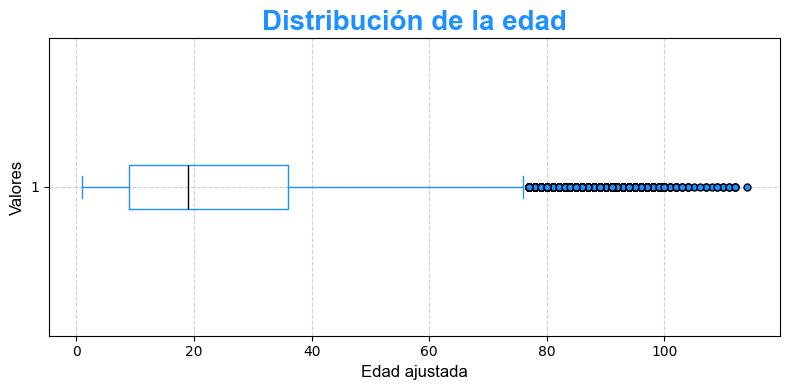

In [6]:
plt.figure(figsize=(8, 4))
plt.title("Distribución de la edad", fontsize=20, fontname='Arial', fontweight='bold', color='dodgerblue')
plt.boxplot(df['EDAD_AJUSTADA'], vert=False,
            boxprops=dict(color='dodgerblue'),
            medianprops=dict(color='black'),
            whiskerprops=dict(color='dodgerblue'),
            capprops=dict(color='dodgerblue'),
            flierprops=dict(markerfacecolor='dodgerblue', marker='o', markersize=5))
plt.xlabel("Edad ajustada", fontsize=12, fontname='Arial')
plt.ylabel("Valores", fontsize=12, fontname='Arial')
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

In [29]:
# Grupos etarios de interes
menores_5 = df[df["EDAD_AJUSTADA"] <= 5]
mayores_65 = df[df["EDAD_AJUSTADA"] >= 65]

# Calcular estadísticas
total_pacientes = len(df)
cantidad_menores_5 = len(menores_5)
cantidad_mayores_65 = len(mayores_65)

porcentaje_menores_5 = round((cantidad_menores_5 / total_pacientes) * 100, 3)
porcentaje_mayores_65 = round((cantidad_mayores_65 / total_pacientes) * 100, 3)

# Crear la tabla
tabla_edad = pd.DataFrame({
    "Grupo Etario": ["Menores de 5 años", "Mayores de 65 años"],
    "Cantidad de Pacientes": [cantidad_menores_5, cantidad_mayores_65],
    "Porcentaje del Total": [porcentaje_menores_5, porcentaje_mayores_65]
})
tabla_edad

,Grupo Etario,Cantidad de Pacientes,Porcentaje del Total
0,Menores de 5 años,82018,14.430
1,Mayores de 65 años,28436,5.003


La distribución de edad de los pacientes con dengue presenta una asimetría positiva marcada (coeficiente de skewness = +1.8), con una media de 24.5 años (±19.67 DE) y una mediana de 19 años. Se observa que el 50% de los casos se concentra entre los 9 y 36 años, lo que sugiere una mayor exposición al vector en la población escolar y económicamente activa. 

Los valores atípicos superiores a 76 años (0.2% del total) establecidos como casos excepcionales de longevidad con infección confirmada.

#### 🔹 Características demográficas

In [8]:
# Sexo
df["SEXO"] = df["SEXO_NUM"].map({0: "Femenino", 1: "Masculino"})
tabla_sexo = df["SEXO"].value_counts().reset_index()
tabla_sexo.columns = ["Sexo", "Cantidad de Pacientes"]
tabla_sexo["Porcentaje del Total"] = round((tabla_sexo["Cantidad de Pacientes"] / tabla_sexo["Cantidad de Pacientes"].sum()) * 100, 3)

print("Distribución de pacientes por sexo:")
tabla_sexo


Distribución de pacientes por sexo:


,Sexo,Cantidad de Pacientes,Porcentaje del Total
0,Masculino,297880,52.41
1,Femenino,270488,47.59


In [9]:
# Tipo de aseguradora
tabla_SS = df["TIP_SS"].value_counts().reset_index()
tabla_SS.columns = ["Tipo de aseguradora", "Cantidad de Pacientes"]
tabla_SS["Porcentaje del Total"] = round((tabla_SS["Cantidad de Pacientes"] / tabla_SS["Cantidad de Pacientes"].sum()) * 100, 3)

print("Distribución de pacientes por aseguradora:")
tabla_SS

Distribución de pacientes por aseguradora:


,Tipo de aseguradora,Cantidad de Pacientes,Porcentaje del Total
0,C,270865,47.657
1,S,241212,42.439
2,N,22055,3.880
3,P,16972,2.986
4,E,15040,2.646
5,I,2224,0.391


In [10]:
# Grupos poblacionales de interes
grupo_cols = ["GP_MIGRANT","GP_GESTAN","GP_POBICFB"]
conteo_grupos = df[grupo_cols].apply(lambda x: (x == 1).sum())
nombres_grupos = {
    "GP_MIGRANT": "Migrante",
    "GP_GESTAN": "Gestante",
    "GP_POBICFB": "Población con ICBF"
}
tabla_grupos = pd.DataFrame({
    "Grupo de Pertenencia": [nombres_grupos[col] for col in grupo_cols],
    "Cantidad de Personas": conteo_grupos.values
})
print("Pertenencia a grupos de interés")
tabla_grupos

Pertenencia a grupos de interés


,Grupo de Pertenencia,Cantidad de Personas
0,Migrante,1854
1,Gestante,3871
2,Población con ICBF,807


In [11]:
# Area de ocurrencia
df["AREA"] = df["AREA"].map({1: "Cabecera municipal", 3: "Centros poblados", 2: "Rural disperso"})
tabla_a = df["AREA"].value_counts().reset_index()
tabla_a.columns = ["Area de vivienda", "Cantidad de Pacientes"]
tabla_a["Porcentaje del Total"] = round((tabla_SS["Cantidad de Pacientes"] / tabla_SS["Cantidad de Pacientes"].sum()) * 100, 3)

print("Distribución de pacientes por area de residencia:")
tabla_a

Distribución de pacientes por area de residencia:


,Area de vivienda,Cantidad de Pacientes,Porcentaje del Total
0,Cabecera municipal,465116,47.657
1,Centros poblados,52453,42.439
2,Rural disperso,50799,3.880


En cuanto a la distribución por sexo, se observa un equilibrio relativo (52.4% hombres vs 47.6% mujeres), consistente con la exposición universal al vector. Respecto al sistema de salud, 90.1% de los casos pertenecen a los regímenes contributivo (47.7%) o subsidiado (42.4%), reflejando la cobertura del sistema de salud colombiano. Llama la atención la baja representación de zonas rurales dispersas (3.9%), que podría indicar subnotificación en áreas con menor acceso a servicios médicos.

Los grupos especiales muestran frecuencias esperadas: 3871 son gestantes y 807 pertenecen al ICBF, que incluye menores en protección estatal.

### 2.3.2. Ubicación geográfica

#### 🔹 Departamentos

In [5]:
tabla_dptos = pd.DataFrame({
    "Departamento": df["DPTO_OCU"].value_counts().nlargest(10).index,
    "Casos": df["DPTO_OCU"].value_counts().nlargest(10).values
})

# Calculando la frecuencia relativa
tabla_dptos["Frecuencia (%)"] = round((tabla_dptos["Casos"] / df["DPTO_OCU"].count()) * 100,2)

print("Top 10 departamentos de mayor ocurrencia")
tabla_dptos



Top 10 departamentos de mayor ocurrencia


,Departamento,Casos,Frecuencia (%)
0,VALLE,90132,15.86
1,ANTIOQUIA,57301,10.08
2,SANTANDER,55416,9.75
3,TOLIMA,50123,8.82
4,META,41892,7.37
5,NORTE SANTANDER,33666,5.92
6,HUILA,30716,5.40
7,ATLANTICO,26944,4.74
8,CUNDINAMARCA,20814,3.66
9,CESAR,19937,3.51


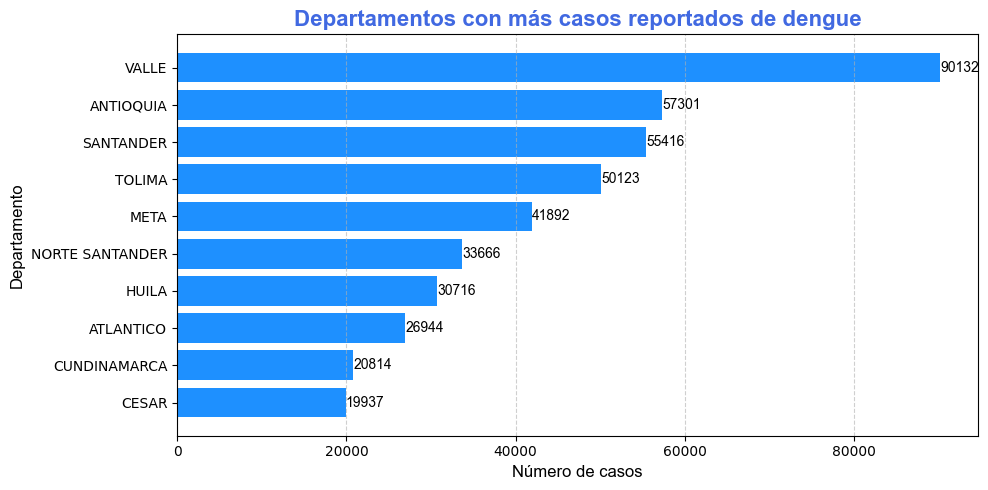

In [27]:
# Datos
df_filtered = df["DPTO_OCU"].value_counts().nlargest(10)
df_plot = pd.DataFrame({
    "Departamento": df_filtered.index,
    "Frecuencia": df_filtered.values
})

# Gráfico
plt.figure(figsize=(10, 5))
bars = plt.barh(df_plot["Departamento"], df_plot["Frecuencia"], color='dodgerblue')
for bar in bars:
    width = bar.get_width()
    plt.text(width + 5, bar.get_y() + bar.get_height()/2,
             f"{int(width)}", va='center', fontsize=10, fontname='Arial')

# Títulos y etiquetas
plt.title("Departamentos con más casos reportados de dengue", fontsize=16, color="royalblue", fontname='Arial', weight='bold')
plt.xlabel("Número de casos", fontsize=12, fontname='Arial')
plt.ylabel("Departamento", fontsize=12, fontname='Arial')
plt.grid(axis='x', linestyle='--', alpha=0.6)

# Estética general
plt.gca().invert_yaxis()  # Para que el más alto quede arriba
plt.tight_layout()
plt.show()


In [12]:
df_filtered = df["DPTO_OCU"].value_counts().nsmallest(5)
df_min = pd.DataFrame({
    "Departamento": df_filtered.index,
    "Frecuencia": df_filtered.values
})
df_min = df_min.sort_values(by="Frecuencia", ascending=True)
print("Departamentos con menor ocurrencia")
df_min

Departamentos con menor ocurrencia


,Departamento,Frecuencia
0,PROCEDENCIA DESCONOCIDA,45
1,VAUPES,177
2,BOGOTA,317
3,SAN ANDRES,450
4,GUAINIA,650


El análisis por departamentos revela una distribución heterogénea de los casos de dengue en Colombia, con marcadas diferencias entre regiones. Los datos muestran que Valle del Cauca es el departamento con la mayor carga de la enfermedad, registrando 90,132 casos, lo que representa aproximadamente el 15.8% del total nacional analizado. Le siguen en importancia Antioquia (57,301 casos, 10.1%) y Santander (55,416 casos, 9.7%), conformando así los tres departamentos con mayor incidencia.

Otros departamentos con cifras significativas incluyen a: 
* Tolima: 50,123 casos (8.8%)
* Meta: 41,892 casos (7.4%)
* Norte de Santander: 33,666 casos (5.9%)

En contraste, los departamentos con menor reporte de casos son:
* Vaupés: 177 casos (0.03%)
* San Andrés: 450 casos (0.08%)
* Guainía: 650 casos (0.11%)

#### 🔹 Departamentos por densidad poblacional

```{note}
Para el análisis demográfico, se han tomado los datos proporcionados por el censo poblacional del DANE (2018) para referenciar la cantidad de casos por población.

In [13]:
deptos = pd.read_csv(r"C:\Users\Hp\MACHINE\data\poblacion_departamentos.csv")
# Crear un diccionario con los nombres correctos
mapeo_deptos = {
    "BOGOTA, D.C.": "BOGOTA",
    "LA GUAJIRA": "GUAJIRA",
    "VALLE DEL CAUCA": "VALLE",
    "SAN ANDRES, PROVIDENCIA Y SANTA CATALINA": "SAN ANDRES",
    "NORTE DE SANTANDER": "NORTE SANTANDER"
}
# Aplicar el reemplazo en el DataFrame
deptos["DEPARTAMENTO"] = deptos["DEPARTAMENTO"].replace(mapeo_deptos)

In [25]:
# Contar los casos por departamento
casos_por_dpto = df["DPTO_OCU"].value_counts().reset_index()
casos_por_dpto.columns = ["Departamento", "Total Casos"]

df_densidad = casos_por_dpto.merge(deptos, left_on="Departamento", right_on="DEPARTAMENTO", how="left")
df_densidad["Densidad Casos"] = round((df_densidad["Total Casos"] / df_densidad["CENSO"]) * 10000,2)
df_densidad = df_densidad.sort_values(by="Densidad Casos", ascending=False)

df_densidad.head(10)


,Departamento,Total Casos,DEPARTAMENTO,CENSO,Densidad Casos
4,META,41892,META,1039722.0,402.92
3,TOLIMA,50123,TOLIMA,1330187.0,376.81
23,GUAVIARE,2920,GUAVIARE,82767.0,352.80
13,CASANARE,13201,CASANARE,420504.0,313.93
6,HUILA,30716,HUILA,1100386.0,279.14
2,SANTANDER,55416,SANTANDER,2184837.0,253.64
26,AMAZONAS,1891,AMAZONAS,76589.0,246.90
14,QUINDIO,12831,QUINDIO,539904.0,237.65
16,PUTUMAYO,8224,PUTUMAYO,348182.0,236.20
5,NORTE SANTANDER,33666,NORTE SANTANDER,1491689.0,225.69


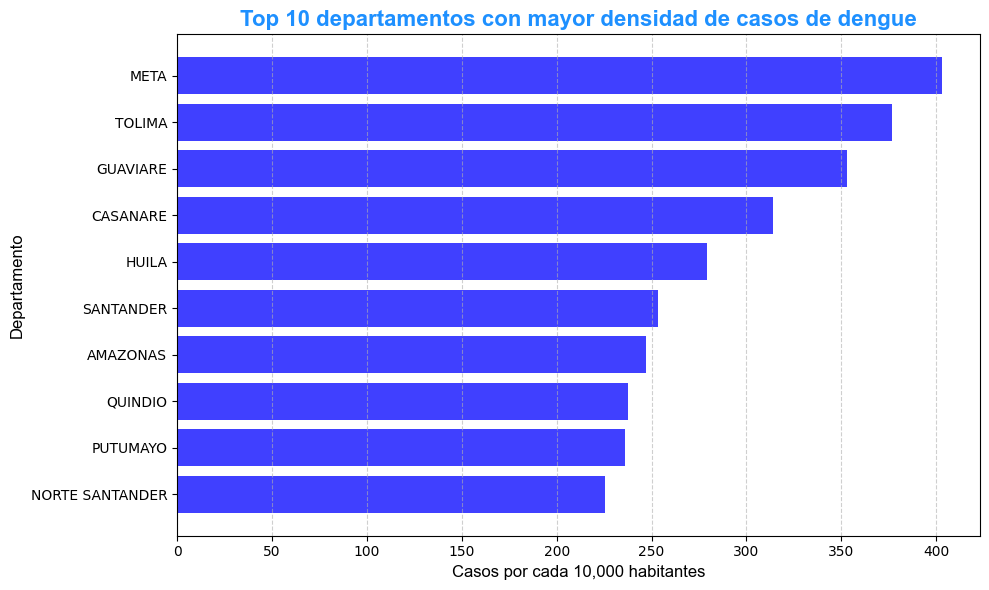

In [28]:
# Seleccionar los 10 departamentos con mayor densidad de casos
df_plot = df_densidad[["Departamento", "Densidad Casos"]].head(10).copy()

# Crear la figura y el eje
fig, ax = plt.subplots(figsize=(10, 6))

# Crear el gráfico de barras
ax.barh(df_plot["Departamento"], df_plot["Densidad Casos"], color="blue", alpha=0.75)

# Títulos y etiquetas
ax.set_title("Top 10 departamentos con mayor densidad de casos de dengue", fontsize=16, color="dodgerblue", fontname='Arial', weight='bold')
ax.set_xlabel("Casos por cada 10,000 habitantes", fontsize=12, fontname='Arial')
ax.set_ylabel("Departamento", fontsize=12, fontname='Arial')

# Estética adicional
ax.grid(axis='x', linestyle='--', alpha=0.6)
ax.invert_yaxis()  # Para que el departamento con mayor densidad quede arriba
plt.tight_layout()

# Mostrar la gráfica
plt.show()

Los datos revelan patrones epidemiológicos críticos al analizar la densidad de casos ajustada por población. Meta emerge como el departamento con mayor riesgo relativo, registrando 402.9 casos por 100,000 habitantes, seguido de cerca por Tolima (376.8) y Guaviare (352.8). Este hallazgo sugiere que estas regiones enfrentan presión epidemiológica desproporcionada, incluso comparadas con departamentos más poblados.
La densidad de casos revela que el riesgo epidémico no se distribuye proporcionalmente al tamaño poblacional. 


### **Temporales**

#### 🔹 Pacientes por año

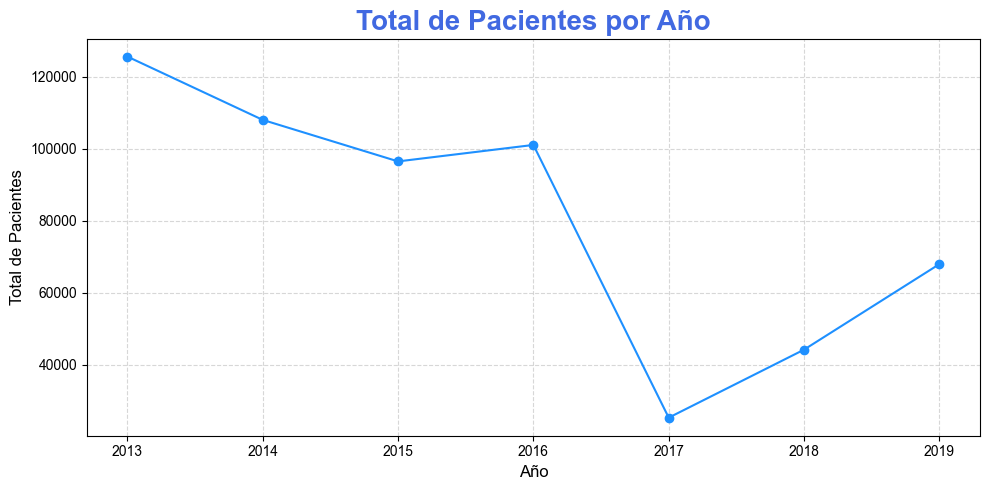

In [38]:
# Agrupar por año y contar total de pacientes
total_pacientes_por_año = df.groupby("ANO").size().reset_index(name="Total Pacientes")

# Establecer la fuente personalizada
plt.rcParams['font.family'] = 'Arial'  # Asegúrate de tener esta fuente instalada o elige otra

# Crear figura
plt.figure(figsize=(10, 5))
plt.plot(total_pacientes_por_año["ANO"], total_pacientes_por_año["Total Pacientes"],
         marker='o', color='dodgerblue')

# Títulos y etiquetas
plt.title("Total de Pacientes por Año", fontsize=20, color="royalblue", weight="bold")
plt.xlabel("Año", fontsize=12)
plt.ylabel("Total de Pacientes", fontsize=12)

# Ajustes de ejes
plt.xticks(total_pacientes_por_año["ANO"])  # Forzar ticks enteros si es necesario
plt.grid(True, linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()

El análisis temporal revela un comportamiento cíclico marcado, caracterizado por fluctuaciones interanuales típicas de enfermedades transmitidas por vectores. El periodo inicia con un pico epidémico en 2013 (más de 120,000 casos). Posteriormente, se observa una disminución progresiva hasta 2015, seguida de un mínimo histórico en 2017 (25,284 casos). A partir de 2018, se evidencia un repunte sostenido, alcanzando cerca de 70,000 casos en 2019.


Nota clave: Los ciclos epidémicos ocurren cada 3-5 años, lo que sugiere ventanas críticas para intervenciones preventivas.

#### 🔹 Pacientes por semana epidemiológica

>La variable representa la semana epidemiológica en la que ocurrió el evento de acuerdo al calendario Colombiano para cada año. Tener en cuenta que en el año $2014$ se requirió de adición de la semana 53.

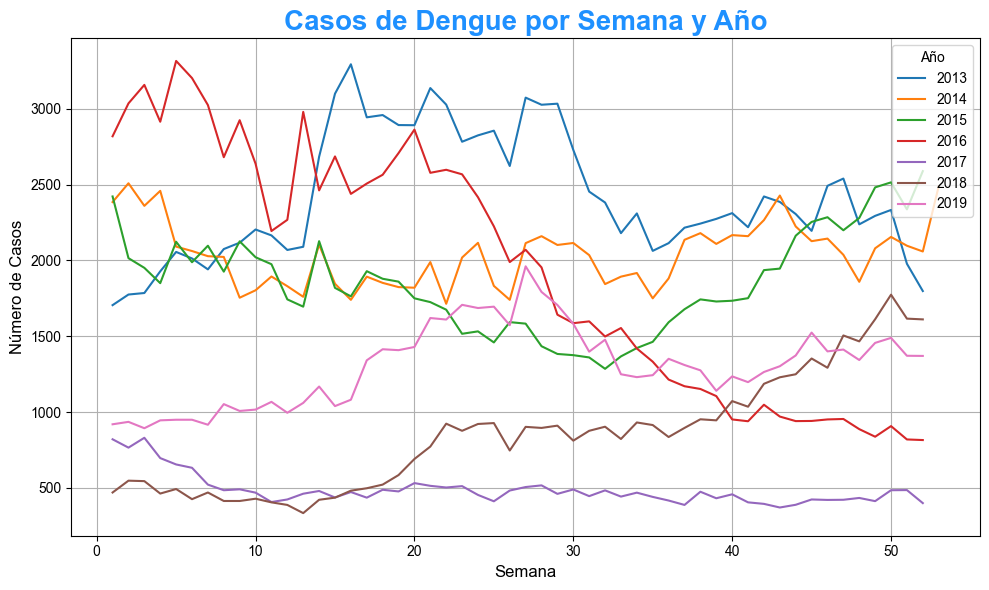

In [43]:
# Agrupar los casos por semana y año
conteo_semanal_anual = df.groupby(["ANO", "SEMANA"]).size().reset_index(name="Casos")

# Configuración del gráfico
fig, ax = plt.subplots(figsize=(10, 6))

# Graficar los casos por cada año
for ano in conteo_semanal_anual['ANO'].unique():
    df_ano = conteo_semanal_anual[conteo_semanal_anual['ANO'] == ano]
    ax.plot(df_ano['SEMANA'], df_ano['Casos'], label=str(ano))

# Personalizar el gráfico
ax.set_title("Casos de Dengue por Semana y Año", fontsize=20, fontweight='bold', color='dodgerblue', family='Arial')
ax.set_xlabel("Semana", fontsize=12)
ax.set_ylabel("Número de Casos", fontsize=12)
ax.legend(title="Año")
ax.grid(True)

# Mostrar el gráfico
plt.tight_layout()
plt.show()


El análisis por semana epidemiológica revela patrones diferenciados en la incidencia del dengue a lo largo del periodo estudiado:

En 2013 se registró la mayor variabilidad semanal, con oscilaciones entre 1,700 y 3,200 casos. Los años 2014 y 2015 presentaron un comportamiento más estable, manteniéndose en rangos de 1,800 a 2,500 casos semanales. Durante 2016 se evidenció una disminución progresiva en el número de casos semana a semana.

El año 2017 mostró la menor fluctuación interanual, con una escasa variación en los reportes semanales. Para 2018 se documentó un incremento sostenido en las cifras a medida que avanzaban las semanas. En 2019 destacó un marcado pico epidemiológico en la semana 27.

Los datos indican que la mayor carga de casos se concentró entre las semanas 18 y 24, con puntos máximos adicionales en las semanas 5 y 27. Esta distribución refleja patrones estacionales característicos de la transmisión del dengue en la región. En cambio, entre las semanas 32 y 41, se tiene la menor notificación de casos. 

In [38]:
# tabla
tabla_semana = pd.DataFrame({
    "Semana": df["SEMANA"].value_counts().nlargest(10).index,
    "Casos": df["SEMANA"].value_counts().nlargest(10).values,
}).sort_values(by="Casos") 
print("Top 10 de Semanas con mayor ocurrencia")
tabla_semana

Top 10 de Semanas con mayor ocurrencia


,Semana,Casos
9,10,11968
8,8,12113
7,9,12432
6,4,12705
5,7,12766
4,1,12907
3,2,13126
2,6,13216
1,3,13310
0,5,13504


### **Datos clínicos**

#### 🔹 Evento

In [55]:
# Tabla
tabla_eve = pd.DataFrame({
    "Evento": df["EVENTO"].value_counts().index,
    "Pacientes": df["EVENTO"].value_counts().values,
})
tabla_eve["Porcentaje"] = round((tabla_eve["Pacientes"] / tabla_eve["Pacientes"].sum()) * 100, 3)
print("Distribución de eventos")
tabla_eve

Distribución de eventos


,Evento,Pacientes,Porcentaje
0,DENGUE,559561,98.45
1,DENGUE GRAVE,8807,1.55


#### 🔹 Decesos por evento

In [57]:
# Descensos por evento
df_decesos = df[df["CON_FIN"] == 2]  
tabla_decesos = df_decesos["EVENTO"].value_counts().reset_index()
tabla_decesos.columns = ["Evento", "Decesos"]
print("Cantidad de decesos por evento")
tabla_decesos

Cantidad de decesos por evento


,Evento,Decesos
0,DENGUE GRAVE,239
1,DENGUE,15


Solo el $0.05$% de los pacientes murieron a causa de la enfermedad.

#### 🔹 Estado del caso
El estado de confirmación del caso por paciente fue catalogado como probable, confirmado por laboratorio o confirmado por nexo epidemiológico.

In [21]:
nombres_caso = {
    2: "Caso probable",
    3: "Caso confirmado por laboratorio",
    5: "Caso confirmado por nexo epidemiológico",
}
tabla_caso = pd.DataFrame({
    "Nombre del Caso": nombres_caso.values(),
    "Cantidad de pacientes": df["TIP_CAS"].value_counts().values,
    "Porcentaje del Total": round((df["TIP_CAS"].value_counts() / df["TIP_CAS"].value_counts().sum()) * 100, 3)
})
print("Estado del caso")
tabla_caso

Estado del caso


,Nombre del Caso,Cantidad de pacientes,Porcentaje del Total
TIP_CAS,,,
2,Caso probable,441428,77.666
3,Caso confirmado por laboratorio,120563,21.212
5,Caso confirmado por nexo epidemiológico,6377,1.122


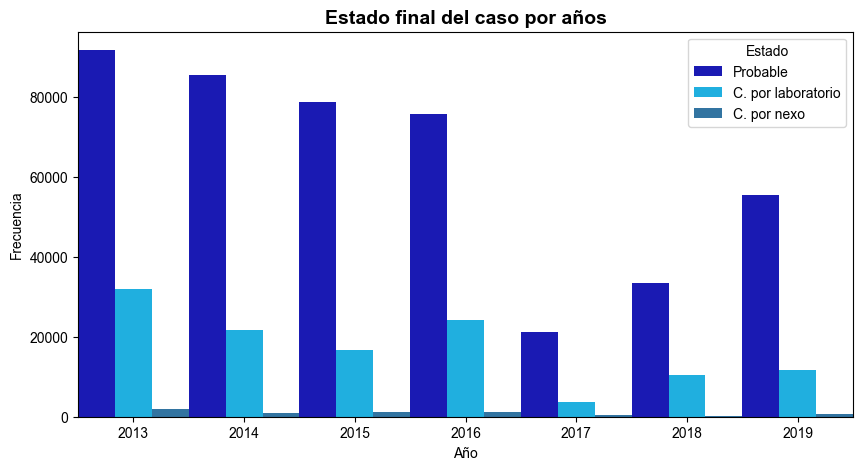

In [62]:
# Gráfico
plt.figure(figsize=(10, 5))
sns.countplot(data = df, x= "ANO", hue="TIP_CAS", palette=["mediumblue", "deepskyblue", "#1f77b4"], width= True)
plt.title("Estado final del caso por años", fontsize=14, fontweight="bold")
plt.ylabel("Frecuencia")
plt.xlabel("Año")
plt.legend(title="Estado", labels = ["Probable", "C. por laboratorio", "C. por nexo"])
plt.show()

El análisis de los casos reportados según su estado final revela que la mayoría fueron clasificados como probables durante todo el periodo estudiado. Entre 2013 y 2016, se observó una reducción progresiva en el número de estos casos, con una disminución particularmente marcada en 2017, seguida de un repunte hacia 2019.

Por otro lado, los casos confirmados por laboratorio presentaron una tendencia similar, aunque con una particularidad: en 2016 se registró un aumento atípico en las confirmaciones, en contraste con la disminución general observada en los casos probables para ese mismo año.

Esta distribución temporal sugiere variaciones en las prácticas de diagnóstico y confirmación a lo largo del periodo analizado.

#### 🔹 Casos confirmados
Para la notificación de cada caso, la variable de confirmación toma el valor 1 para casos confirmados y 0 para casos no confirmados

In [6]:
tabla_conf = pd.DataFrame({
    "Confirmados": df["CONFIRMADOS"].value_counts().index,
    "Pacientes": df["CONFIRMADOS"].value_counts().values,
    "Porcentaje": round(df["CONFIRMADOS"].value_counts(normalize=True) * 100, 2)
})

print("Cantidad de casos confirmados")
tabla_conf


Cantidad de casos confirmados


,Confirmados,Pacientes,Porcentaje
CONFIRMADOS,,,
0,0,290232,51.06
1,1,278136,48.94


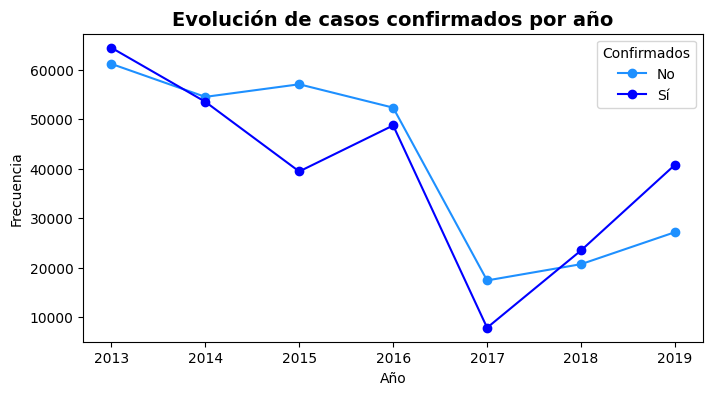

In [10]:
# Agrupar por año y confirmación
df_line = df.groupby(["ANO", "CONFIRMADOS"]).size().reset_index(name="Frecuencia")

# Crear el gráfico de líneas
plt.figure(figsize=(8, 4))

# Asignar colores manualmente
colores = {0: "dodgerblue", 1: "blue"}

for confirmado in df_line["CONFIRMADOS"].unique():
    subset = df_line[df_line["CONFIRMADOS"] == confirmado]
    label = "Sí" if confirmado == 1 else "No"
    plt.plot(subset["ANO"], subset["Frecuencia"], marker='o', label=label, color=colores[confirmado])

plt.title("Evolución de casos confirmados por año", fontsize=14, fontweight="bold")
plt.xlabel("Año")
plt.ylabel("Frecuencia")
plt.legend(title="Confirmados")
plt.show()


En su mayoría, el 51.06% los casos no fueron confirmados para dengue y el otro 48.94% fueron confirmados.
Con respecto a los casos confirmados, en la mayoría de los años fue mayor la cantidad de casos no confirmados. En el año 2015 se presenta la mayor diferencia entre los casos que fueron confirmados y los que no.


#### 🔹 Hospitalización
Pacientes que requirieron hospitalización por enfermedad, se clasifica en (1) Hospitalizados (2) No Hospitalizados.

In [22]:
# Pacientes hospitalizados

# Tabla
tabla_hosp = pd.DataFrame({
    "Hospitalizacion": df["PAC_HOS"].value_counts().index,
    "Pacientes": df["PAC_HOS"].value_counts().values,
})
tabla_hosp["Porcentaje"] = round((tabla_hosp["Pacientes"] / tabla_hosp["Pacientes"].sum()) * 100, 3)
print("Distribución de hospitalizados")
tabla_hosp

Distribución de hospitalizados


,Hospitalizacion,Pacientes,Porcentaje
0,2,351147,61.782
1,1,217221,38.218


#### Hospitalización de pacientes por año

In [23]:
# Pacientes hospitalizados por año|

#Tabla
tabla_hosp_year = df.groupby("ANO")["PAC_HOS"].value_counts().unstack().fillna(0)
tabla_hosp_year.columns = ["No Hospitalizado (2)", "Hospitalizado (1)"]

print("Cantidad de pacientes hospitalizados por año")
tabla_hosp_year

Cantidad de pacientes hospitalizados por año


,No Hospitalizado (2),Hospitalizado (1)
ANO,,
2013,49735,75819
2014,39345,68630
2015,34390,62054
2016,30328,70688
2017,9035,16249
2018,21810,22361
2019,32578,35346


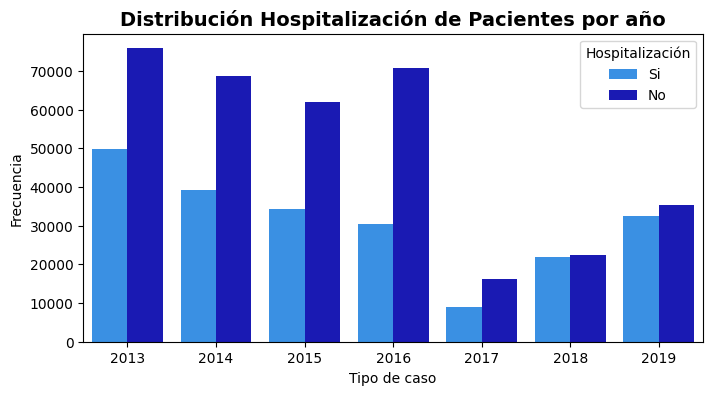

In [24]:
# Gráfica
plt.figure(figsize=(8, 4))
sns.countplot(x="ANO", data = df, hue = "PAC_HOS", legend = True, palette=["dodgerblue", "mediumblue"])
plt.title("Distribución Hospitalización de Pacientes por año", fontsize=14, fontweight="bold")
plt.ylabel("Frecuencia")
plt.xlabel("Tipo de caso")
plt.legend(title = "Hospitalización", labels = ["Si", "No"])
plt.show()